# Neural nets and ensembles

## Preprocessing 

This work will be done with Online News Popularity dataset. Let's start with importing required libraries and take a bdief look of dataset.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 

import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

df = pd.read_csv("C:\ONU EDU\ML\OnlineNewsPopularityReduced.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            4954 non-null   object 
 1   timedelta                      4954 non-null   int64  
 2   n_tokens_title                 4954 non-null   int64  
 3   n_tokens_content               4954 non-null   int64  
 4   n_unique_tokens                4954 non-null   float64
 5   n_non_stop_words               4954 non-null   float64
 6   n_non_stop_unique_tokens       4954 non-null   float64
 7   num_hrefs                      4954 non-null   int64  
 8   num_self_hrefs                 4954 non-null   int64  
 9   num_imgs                       4954 non-null   int64  
 10  num_videos                     4954 non-null   int64  
 11  average_token_length           4954 non-null   float64
 12  num_keywords                   4954 non-null   i

As we can see all data in the dataset is already numeric, except for the first "URL" column, but the link does not affect the popularity of the article in any way. So, you can simply remove it, then if necessary, you can easily find the link to the article by the row id.

Also deeper analysis of dataset has shown that the in "kw_min_min" column all values are equal to -1, so we don't need it.

In [2]:
df = df.drop("url", axis=1)
df = df.drop("kw_min_min", axis=1)

Now let's get down to the target and it's distribution

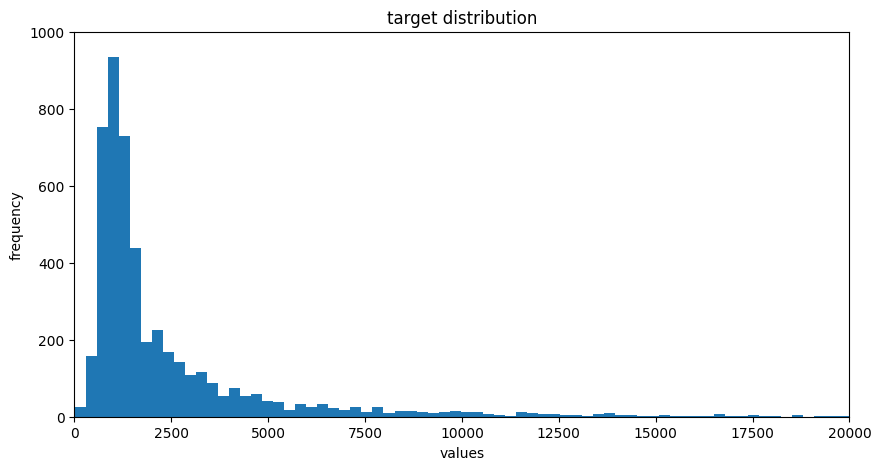

In [3]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(df["shares"], bins=1000)
ax.set_xlabel("values")
ax.set_ylabel("frequency")
ax.set_title("target distribution")

ax.set_xlim(0, 20000)
ax.set_ylim(0, 1000)

plt.show()

As we can see this distribution is far cry from normal distribution and looks more like log-normal or exp distribution. So I decided to use numpy.log function, it can make distribution more appealing.

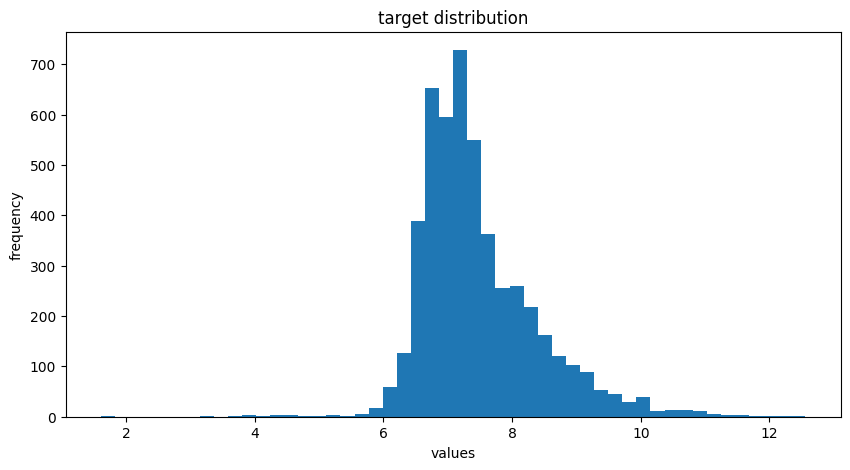

In [4]:
df['shares'] = np.log(df['shares'])

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(df["shares"], bins=50)
ax.set_xlabel("values")
ax.set_ylabel("frequency")
ax.set_title("target distribution")
plt.show()

The result looks more like normal distribution, so further calculations will be done on basis of that result.

Now time to move from regression model to classification, because previous expirience with that dataset has shown that it is not optimal to use regressor.

So the idea of classification is to make 3 groups based on our distribution, using mean and standart deviation.

In [5]:
mean_shares = np.mean(df['shares'])
std_shares = df['shares'].std()

category_1_upper = mean_shares - 0.5*std_shares
category_2_lower = mean_shares - 0.5*std_shares
category_2_upper = mean_shares + 0.5*std_shares
category_3_lower = mean_shares + 0.5*std_shares

conditions = [
    (df['shares'] < category_1_upper),
    (df['shares'] >= category_2_lower) & (df['shares'] <= category_2_upper),
    (df['shares'] > category_3_lower)
]

values = [1, 2, 3]

df['shares'] = np.select(conditions,values)
print(df['shares'].value_counts())


shares
1    1869
2    1851
3    1234
Name: count, dtype: int64


Alse let's scale our data to improve numerical stability and interpretability, it is not the most important part, but it may improve result when there are outliers.

In [6]:
from sklearn.preprocessing import StandardScaler

X = df.drop('shares', axis=1)
y = df['shares']

scaler = StandardScaler()
X_st = scaler.fit_transform(X)

Move on to the splitting up the dataset into test and training sets.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_st, y, test_size=0.25, random_state=42)

## Neural nets modeling

Let's start with Multi-layer Perceptron classifier and build model with default parameters

In [8]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_valid)

accuracy = accuracy_score(y_valid, y_pred)
conf_matrix = confusion_matrix(y_valid, y_pred)
classification_rep = classification_report(y_valid, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')


Accuracy: 0.46246973365617433
Confusion Matrix:
[[224 148  81]
 [150 210 106]
 [ 56 125 139]]
Classification Report:
              precision    recall  f1-score   support

           1       0.52      0.49      0.51       453
           2       0.43      0.45      0.44       466
           3       0.43      0.43      0.43       320

    accuracy                           0.46      1239
   macro avg       0.46      0.46      0.46      1239
weighted avg       0.46      0.46      0.46      1239



As we can see our model is working, but we have a lack of accuracy. So further actions will be directed to model improvement and hyperparameters tunning.

### Hyperparameters tuning

function to draw validation curves

In [9]:
def draw(model_grid, param_name, params=None):
    results_df = pd.DataFrame(model_grid.cv_results_)
    
    if params == None:
        plt.plot(results_df['param_'+param_name], results_df['mean_test_score'])
    else:
        plt.plot(params, results_df['mean_test_score'])

    plt.xlabel(param_name)
    plt.ylabel('Score')
    plt.title('Validation curve')
    plt.grid(True)
    plt.show()

In this section we will try to improve our model using different hyperparameters to find their best values.

Let's start from neurons number parameter

best params {'hidden_layer_sizes': (250,)}, best score 0.48075370121130545


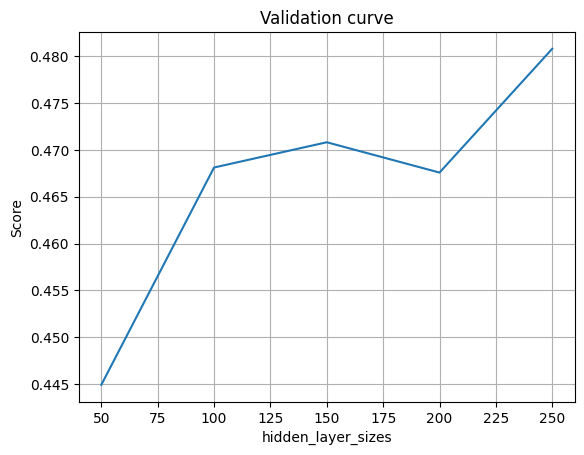

In [10]:

from sklearn.model_selection import GridSearchCV

param_grid = {'hidden_layer_sizes': [(50,), (100,), (150,), (200,), (250,)]}

model = MLPClassifier(max_iter=1000, random_state=42)

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"best params {grid_search.best_params_}, best score {grid_search.best_score_}")

draw(grid_search,'hidden_layer_sizes',[i for i in range(50, 300, 50)])

best params {'hidden_layer_sizes': (200, 200)}, best score 0.47590847913862716


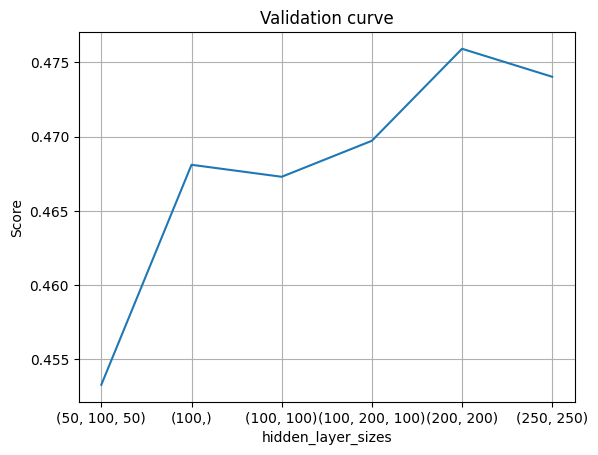

In [12]:
param_grid = {'hidden_layer_sizes': [(50,100,50), (100,), (100,100), (100,200,100), (200,200), (250,250)]}

model = MLPClassifier(max_iter=1000, random_state=42)

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"best params {grid_search.best_params_}, best score {grid_search.best_score_}")

draw(grid_search, 'hidden_layer_sizes', [str(i) for i in param_grid['hidden_layer_sizes']])

best params {'activation': 'logistic'}, best score 0.4686406460296097


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


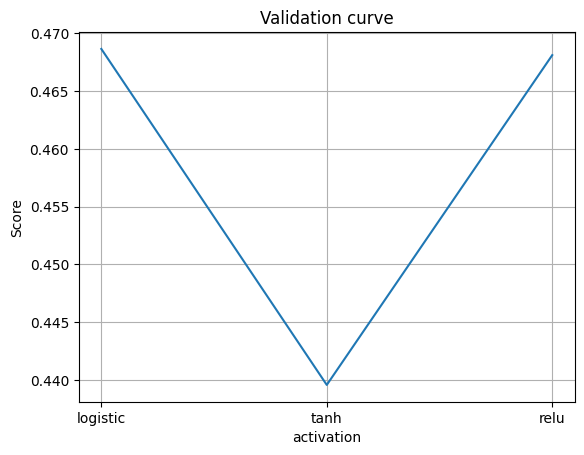

In [13]:
param_grid = {'activation':['logistic', 'tanh', 'relu']}

model = MLPClassifier(max_iter=1000, random_state=42)

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"best params {grid_search.best_params_}, best score {grid_search.best_score_}")

draw(grid_search, 'activation')

best params {'learning_rate_init': 0.0001}, best score 0.4925123765537968


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


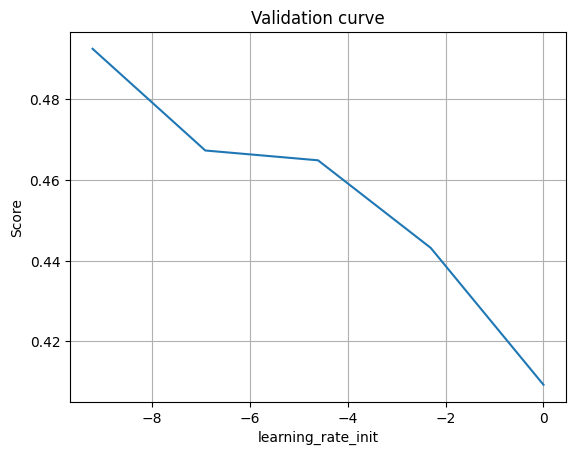

In [40]:
param_grid = {'learning_rate_init': [0.0001, 0.001, 0.01, 0.1, 1.0]}

model = MLPClassifier(max_iter=1000, random_state=42)

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"best params {grid_search.best_params_}, best score {grid_search.best_score_}")

draw(grid_search, 'learning_rate_init', [np.log(i) for i in [0.0001, 0.001, 0.01, 0.1, 1.0]])

As we can see hyperparameters tuning can slightly improve performance of a model even if it is not the optimal combination of all parameters. The best results were achieved in learning rate and neurons number tuning. But on the other hand these method are more time and cpu consuming than default settings.

## Ensembles modeling

### Bagging model based on KNN

starting from base knn model with default settings, only set random state to achieve same results every code run

In [39]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

base_model = KNeighborsClassifier(n_neighbors=100)
bagging = BaggingClassifier(base_model, random_state=42)

bagging.fit(X_train, y_train)

y_pred = bagging.predict(X_valid)

accuracy = accuracy_score(y_valid, y_pred)
conf_matrix = confusion_matrix(y_valid, y_pred)
classification_rep = classification_report(y_valid, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.4705407586763519
Confusion Matrix:
[[329 106  18]
 [228 201  37]
 [125 142  53]]
Classification Report:
              precision    recall  f1-score   support

           1       0.48      0.73      0.58       453
           2       0.45      0.43      0.44       466
           3       0.49      0.17      0.25       320

    accuracy                           0.47      1239
   macro avg       0.47      0.44      0.42      1239
weighted avg       0.47      0.47      0.44      1239



Now let's try to improve this model using hyperparameters tuning, especially tune n_estomators to find the best value

best params {'n_estimators': 20}, best score 0.45361598743974607


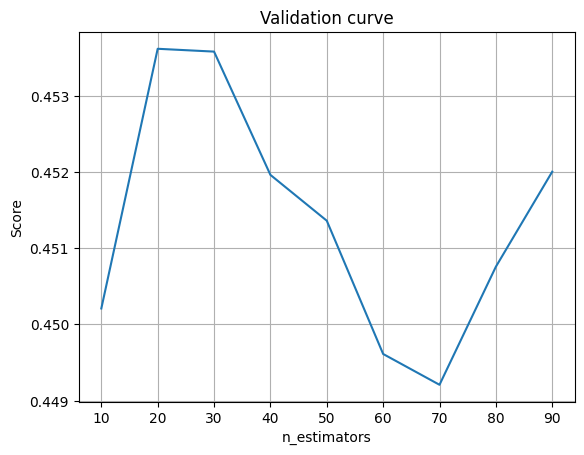

In [47]:
param_grid = {'n_estimators': np.arange(10, 100, 10)}

grid_search = GridSearchCV(bagging, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"best params {grid_search.best_params_}, best score {grid_search.best_score_}")

draw(grid_search, 'n_estimators')

As we can see the best results ocurs on lower number of n_estimators, this scenario is better for time and cpu consumption. Validation curve clearly shows this information

### Boosting model based on decision tree

starting from base decision tree model with default settings, same as previous

In [49]:
from sklearn.ensemble import GradientBoostingClassifier

boost = GradientBoostingClassifier(random_state=42)

boost.fit(X_train, y_train)

y_pred = boost.predict(X_valid)

accuracy = accuracy_score(y_valid, y_pred)
conf_matrix = confusion_matrix(y_valid, y_pred)
classification_rep = classification_report(y_valid, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.5520581113801453
Confusion Matrix:
[[306 110  37]
 [151 246  69]
 [ 64 124 132]]
Classification Report:
              precision    recall  f1-score   support

           1       0.59      0.68      0.63       453
           2       0.51      0.53      0.52       466
           3       0.55      0.41      0.47       320

    accuracy                           0.55      1239
   macro avg       0.55      0.54      0.54      1239
weighted avg       0.55      0.55      0.55      1239



Now we move on to improvents using hyperparameters tuning. We will tune n_estimators

best params {'n_estimators': 70}, best score 0.5473556303941279


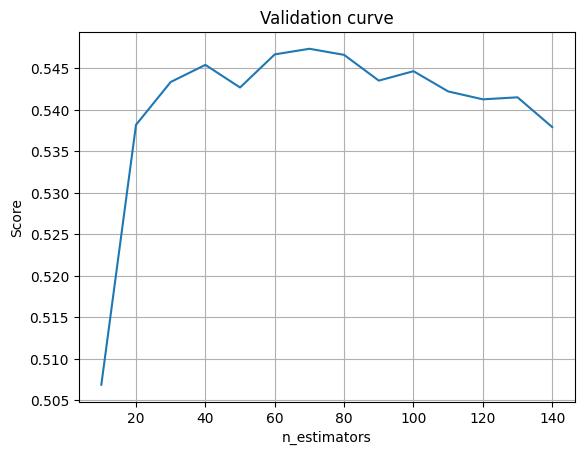

In [51]:
param_grid = {'n_estimators': np.arange(10, 100, 10)}

grid_search = GridSearchCV(boost, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"best params {grid_search.best_params_}, best score {grid_search.best_score_}")

draw(grid_search, 'n_estimators')

In our case boosting model based on decision trees gave noticeably better results than bagging based on knn (aproximately 10%). Validation curve also shows that on average boosting works better. So based on all the information above we can say that boosting method is better in our scenario.